In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import copy
from core.envs.grid_world import *
from core.rl_utils import *

## Create a Neural Network

In [2]:
class Neural_Network():
    def __init__(self, n1=10, n2=10, lr=0.01, input_dim=2, output_dim=4):        
        self.input_dim = input_dim         # Input dimension
        self.output_dim = output_dim       # Output dimension
        self.learning_rate = lr            # Learning rate for SGD
        
        self.n1 = n1                       # Number of neurons in layer 1
        self.n2 = n2                       # Number of neurons in layer 2
        self.n3 = self.output_dim          # Number of neurons in layer 3
        
        # Initialization: weights and biases of layer 1 (Xavier-Initialization)
        fan_in = 1/np.sqrt(self.input_dim)
        self.W1 = 2*fan_in*np.random.random((self.n1, self.input_dim)) - fan_in
        self.b1 = 2*fan_in*np.random.random((self.n1, 1)) - fan_in
        
        # Initialization: weights and biases of layer 2 (Xavier-Initialization)
        fan_in = 1/np.sqrt(self.n1)
        self.W2 = 2*fan_in*np.random.random((self.n2, self.n1)) - fan_in
        self.b2 = 2*fan_in*np.random.random((self.n2, 1)) - fan_in
        
        # Initialization: weights and biases of layer 3 (Xavier-Initialization)
        fan_in = 1/np.sqrt(self.n2)
        self.W3 = 2*fan_in*np.random.random((self.n3, self.n2)) - fan_in
        self.b3 = 2*fan_in*np.random.random((self.n3, 1)) - fan_in
        
    def loss(self, y, y_star, compute_derivative=False):
        l = 0.5*(y_star - y)**2        # MSE criterion
        dldy = 0                       # Default derivative
        if(compute_derivative):
            dldy = -(y_star - y)       # Derivative computation
        return l, dldy

    def f2(self, q, compute_derivative=False): # Activation function of layer 2
        y = q                                  # Linear function
        dydq = 0                               # Default derivative
        if(compute_derivative):
            dydq = np.ones_like(q)             # Derivative computation
        return y, dydq
        
    def f1(self, q, compute_derivative=False): # Activation function of layer 1
        th = (q > 0).astype(float)             # Threshold 
        y = q*th                               # Relu function
        dydq = 0                               # Default derivative
        if(compute_derivative):
            dydq = th                          # Derivative computation
        return y, dydq

    def forward_pass(self, X, track_derivatives=False):
        self.X_in = X.reshape(self.input_dim, -1)         # Check shape
        self.ones_batch = np.ones((self.X_in.shape[1], 1))# Vector with |batch_size| ones
        
        # Forward computations of layer 1        
        Q1 = np.dot(self.W1, self.X_in) + np.dot(self.b1, self.ones_batch.T)   
        self.Y1, self.dY1dQ1 = self.f1(Q1, compute_derivative=track_derivatives)
        
        # Forward computations of layer 2
        Q2 = np.dot(self.W2, self.Y1) + np.dot(self.b2, self.ones_batch.T)
        self.Y2, self.dY2dQ2 = self.f1(Q2, compute_derivative=track_derivatives)
        
        # Forward computations of layer 2
        Q3 = np.dot(self.W3, self.Y2) + np.dot(self.b3, self.ones_batch.T)
        self.Y3, self.dY3dQ3 = self.f2(Q3, compute_derivative=track_derivatives)
        
        return self.Y3.copy() # Return the output of the network
        
    def compute_loss(self, Y, Y_star, track_derivatives=False):
        Y_in = Y.reshape(self.output_dim, -1)                  # Check shape
        Y_star_in = Y_star.reshape(self.output_dim, -1)        # Check shape
        
        L, self.dLdY3 = self.loss(Y_in, Y_star_in, compute_derivative=track_derivatives) # Loss
        return L.sum(1) # Return the cumulative loss of the batch of data
    
    def backward_pass(self): # Must be called after forward_pass() and compute_loss()
        Phi3 = self.dLdY3 * self.dY3dQ3 # Compute the Phi3 matrix      
        dLdY2 = np.dot(self.W3.T, Phi3) # Compute the dLdY2 matrix
        Phi2 = dLdY2 * self.dY2dQ2      # Compute the Phi2 matrix      
        dLdY1 = np.dot(self.W2.T, Phi2) # Compute the dLdY1 matrix
        Phi1 = dLdY1 * self.dY1dQ1      # Compute the Phi1 matrix
        
        self.dLdW1 = np.dot(Phi1, self.X_in.T)     # Compute derivatives of L w.r.t W1
        self.dLdb1 = np.dot(Phi1, self.ones_batch) # Compute derivatives of L w.r.t. b1
        self.dLdW2 = np.dot(Phi2, self.Y1.T)       # Compute derivatives of L w.r.t. W2
        self.dLdb2 = np.dot(Phi2, self.ones_batch) # Compute derivatives of L w.r.t. b2
        self.dLdW3 = np.dot(Phi3, self.Y2.T)       # Compute derivatives of L w.r.t. W3
        self.dLdb3 = np.dot(Phi3, self.ones_batch) # Compute derivatives of L w.r.t. b3
        
    def update_parameters(self): # Applies one gradient descent step to the parameters
        batch_size = np.sum(self.ones_batch)                              # Compute batch_size
        self.W1 = self.W1 - (self.learning_rate/batch_size) * self.dLdW1  # Update W1 using SGD
        self.b1 = self.b1 - (self.learning_rate/batch_size) * self.dLdb1  # Update b1 using SGD
        self.W2 = self.W2 - (self.learning_rate/batch_size) * self.dLdW2  # Update W2 using SGD
        self.b2 = self.b2 - (self.learning_rate/batch_size) * self.dLdb2  # Update b2 using SGD
        self.W3 = self.W3 - (self.learning_rate/batch_size) * self.dLdW3  # Update W3 using SGD
        self.b3 = self.b3 - (self.learning_rate/batch_size) * self.dLdb3  # Update b3 using SGD

## Train the DQN agent

<IPython.core.display.Javascript object>


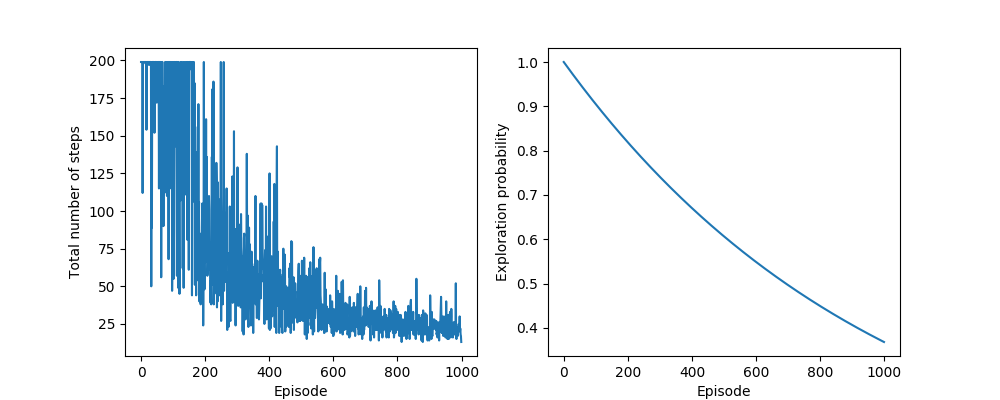

In [3]:
np.random.seed(123)       # For reproducibility

env = Grid_World()        # Instance of the environment
buffer = Replay_Buffer()  # Instance of the replay_buffer (to record experiences)

# Create an instance of the neural network
net = Neural_Network(n1=10, n2=10, lr=0.05, input_dim=env.state_dim, output_dim=env.num_actions)

target_net = copy.deepcopy(net) # Create the target network

num_episodes = 1000             # Number of training episodes
num_steps = 200                 # Number of steps per episode
epsilon = 1.0                   # Initial exploration probability
tau = 0.001                     # Soft-update learning rate
gamma = 0.99                    # Discount factor
min_memory = 1000               # Minimum experiences to collect before training
batch_size = 64                 # Batch size

total_steps_log = []            # Empty list to log number of steps per episode 
epsilon_log = []                # Empty list to log exploration probabilities

for e in range(num_episodes):   # Loop over episodes
    state = env.reset()         # Reset environment
    state = state/7.0           # Normalize state [0, 1]
    
    for s in range(num_steps):  # Loop over steps
        if(np.random.random() <= epsilon): # epsilon-greedy policy                    
            action = np.random.randint(env.num_actions)
        else:
            action = np.argmax(net.forward_pass(state.reshape(-1, 1)))
            
        next_state, reward, done = env.step(action)  # Execute selected action
        next_state = next_state/7.0                  # Normalize next state
        
        buffer.add(state, action, next_state, reward, done) # Record memory
        
        state = next_state   # Update state
        
        if(buffer.count >= min_memory):   # Neural network training
            batch = buffer.sample_batch(batch_size) # Sample a batch of experiences

            states = batch[:, :2]        # Select the states 
            actions = batch[:, 2]        # Select the actions 
            next_states = batch[:, 3:5]  # Select the next states 
            rewards = batch[:, 5]        # Select the rewards
            dones = batch[:, -1]         # Select the termination flags
            
            # Forward pass over the DQN
            Q_values = net.forward_pass(states.T, track_derivatives=True)
            
            # Forward pass over the target DQN
            next_Q_values = target_net.forward_pass(next_states.T, track_derivatives=False)
            targets = Q_values.copy()   # Set intial target values

            # Set the actual target values
            for i in range(batch_size): # This might be vectorized
                targets[int(actions[i]), i] = rewards[i] + gamma * np.max(next_Q_values[:, i]) * (1 - dones[i])

            net.compute_loss(Q_values, targets, track_derivatives=True) # Compute loss
            net.backward_pass()      # Backward pass                
            net.update_parameters()  # Update parameters of main network
            
            # Update parameters of target network (soft-updates)
            target_net.W1 = tau*net.W1 + (1-tau)*target_net.W1
            target_net.b1 = tau*net.b1 + (1-tau)*target_net.b1
            target_net.W2 = tau*net.W2 + (1-tau)*target_net.W2
            target_net.b2 = tau*net.b2 + (1-tau)*target_net.b2
            target_net.W3 = tau*net.W3 + (1-tau)*target_net.W3
            target_net.b3 = tau*net.b3 + (1-tau)*target_net.b3
        
        if(done): # Termination condition
            break    

    total_steps_log.append(s)     # Append total number of steps
    epsilon_log.append(epsilon)   # Append exploration probability 
    epsilon = 0.999 * epsilon     # Exploration decay
    
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(total_steps_log)
plt.xlabel('Episode')
plt.ylabel('Total number of steps')

plt.subplot(122)
plt.plot(epsilon_log)
plt.xlabel('Episode')
plt.ylabel('Exploration probability');

## Testing the trained agent

<IPython.core.display.Javascript object>


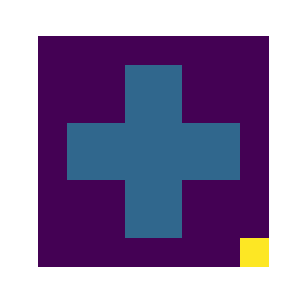

In [4]:
env = Grid_World()      # Create an instance of the environment

for e in range(10):     # Loop over episodes
    state = env.reset() # Reset environment

    for s in range(30):     # Loop over steps
        state = state/7.0   # State normalization
        action = np.argmax(net.forward_pass(state.reshape(-1, 1))) # greedy policy
        state, _, done = env.step(action)  # Execute selected action
        env.render() # Render environment
        
        if(done):   # Termination condition
            break
        

## Visualizing the learned policy

<IPython.core.display.Javascript object>


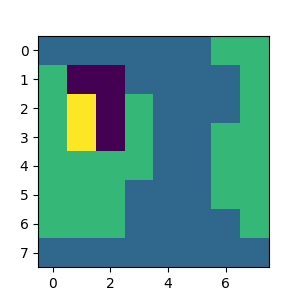

<IPython.core.display.Javascript object>


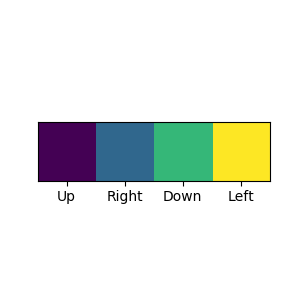

In [5]:
policy = -1*np.ones((8, 8))                                # Initialize policy
for i in range(8):                                         # Loop over rows
    for j in range(8):                                     # Loop over columns
        state = np.array([i, j])/7.0                       # Emulate the state
        policy[i, j] = np.argmax(net.forward_pass(state))  # Save the policy's action

        
# Plot learned policy
plt.figure(figsize=(3,3))
plt.imshow(policy)

# Plot color conventions
plt.figure(figsize=(3,3))
plt.imshow(np.arange(env.num_actions).reshape(1, -1));
plt.yticks([])
plt.xticks([0, 1, 2, 3], ['Up', 'Right', 'Down', 'Left']);